# Building data-set

In [ ]:
import requests
import csv
import os

import pandas as pd

#### Get raw data from API

In [30]:
tickers_df = pd.read_csv('./TICKERS.csv')

for index, row in tickers_df.iterrows():

    ticker = (f'{row["ticker"]}.SAO')
    path = (f'data/{ticker}.csv')

    key = 'XLSA5LZF5KUUXJX3'

    if not os.path.exists(path):
        url = (f'https://www.alphavantage.co/query?apikey={key}&function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&datatype=csv&outputsize=full')

        response = requests.get(url)

        if response.status_code == 200:
            content = response.content.decode()
            
            reader = csv.reader(content.splitlines(), delimiter=',')
            
            dataset = list(reader)
            
            with open(path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerows(dataset)
                
            print(f"New .csv downloaded for {ticker}: {response.status_code}")
        else:
            print(f"Request failed for {ticker}: {response.status_code}")

#### Assemble data-set

In [41]:
def calc_ATR(df):
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    atr_period = len(df)
    df['ATR'] = df['TR'].rolling(atr_period).mean()

    return df['ATR'][len(df)-1]

def calc_OBV(df):

    df['OBV'] = 0
    df.loc[df['close'] > df['close'].shift(1), 'OBV'] = df['volume']
    df.loc[df['close'] < df['close'].shift(1), 'OBV'] = -df['volume']
    df['OBV'] = df['OBV'].cumsum()

    return df['OBV'].mean()


with open("output.csv", mode='w', newline='') as file:
    
    writer = csv.writer(file)
    
    # write header
    writer.writerow(['ticker', 'av_close', 'av_volume', 'av_dividend_amount', 'ATR', 'OBV'])
    
    for index, row in tickers_df.iterrows():
        
        path = (f'data/{row["ticker"]}.SAO.csv')
        df = pd.read_csv(path)
        
        writer.writerow([
                            row['ticker'], 
                            df['close'].mean(), 
                            df['volume'].mean(), 
                            df['dividend_amount'].mean(),
                            calc_ATR(df),
                            calc_OBV(df)
                        ]) 


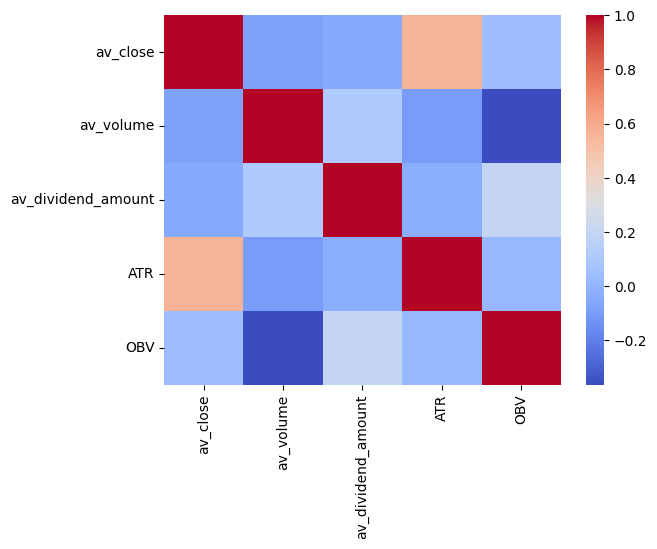

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('output.csv')
del df['ticker']

sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()